In [32]:
from bson import ObjectId
import numpy as np
import pymongo
import statistics
from sklearn import linear_model
import time
from matplotlib import pyplot as plt

In [649]:
# Connect to db and retrieve dataset for test
host="192.168.50.41"
port=27017
db_name='mt'
client = pymongo.MongoClient(host, port)
db = client[db_name]
datColl = db['enctest_dat']

test_id = "008_a"

adc_bits = 2**14
adc_v = 5
adc_sense = adc_v/adc_bits
adc_mm = adc_sense * 2
vals_sense = []
vals_rh1 = []
vals_rh2 = []
vals_rh3 = []
datRecs = {}
for inc, test_rec in enumerate(datColl.find({"test_id": test_id})):
    datRecs[inc] = test_rec

In [650]:
# Assemble intro set - Going from beginning of data through all three read heads into grating
intro_sets = 4
bin_thresh = 1.5
n_ma_sense = 20
intro_sense = []
intro_rh1 = []
intro_rh2 = []
intro_rh3 = []
last_sense = 0
intro_bin_sense = []
intro_bin_rh1 = []
intro_bin_rh2 = []
intro_bin_rh3 = []
for inc, key in enumerate(datRecs):
    if inc <= intro_sets:
        c_intro_sense = []
        c_intro_rh1 = []
        c_intro_rh2 = []
        c_intro_rh3 = []
        if inc > 0:
            last_sense = intro_sense[-1]
        for val in datRecs[key]['vals_sense']:
            cur_sense = (max(datRecs[key]['vals_sense']) - val) * adc_mm + last_sense
            c_intro_sense.append(cur_sense)
        for val in datRecs[key]['vals_rh1']:
            c_intro_rh1.append(val * adc_sense)
            if (val * adc_sense) > 2.4:
                intro_bin_rh1.append(1)
            else:
                intro_bin_rh1.append(0)
        for val in datRecs[key]['vals_rh2']:
            c_intro_rh2.append(val * adc_sense)
            if (val * adc_sense) > 1.8:
                intro_bin_rh2.append(1)
            else:
                intro_bin_rh2.append(0)
        for val in datRecs[key]['vals_rh3']:
            c_intro_rh3.append(val * adc_sense)
            if (val * adc_sense) > 2.2:
                intro_bin_rh3.append(1)
            else:
                intro_bin_rh3.append(0)
        c_intro_sense = np.convolve(c_intro_sense, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        c_intro_rh1 = np.convolve(c_intro_rh1, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        c_intro_rh2 = np.convolve(c_intro_rh2, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        c_intro_rh3 = np.convolve(c_intro_rh3, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        intro_sense.extend(c_intro_sense)
        intro_rh1.extend(c_intro_rh1)
        intro_rh2.extend(c_intro_rh2)
        intro_rh3.extend(c_intro_rh3)
        
vals = np.linspace(0, len(intro_sense), len(intro_sense))        
reg = linear_model.LinearRegression()
sub_t1 = np.array(vals)
sub_t2 = np.array(intro_sense)
sub_sense = np.array(intro_sense)
reg.fit(sub_t1.reshape((-1,1)), sub_sense)
print(f'Slope: {round(reg.coef_[0], 4)} mm/degC')
intro_fit_points = []
for val in vals:
    fit_point = val * reg.coef_[0] + reg.intercept_
    intro_fit_points.append(fit_point)
        

Slope: 0.0022 mm/degC


In [651]:
# Measuring the offsets between read heads

# Build lists of all rising and falling edges in intro datasets
edges_rh1 = []
edges_rh2 = []
edges_rh3 = []
for inc, val in enumerate(intro_bin_rh1):
    if inc > 0:
        delta_rh1 = val - intro_bin_rh1[inc-1]
        if delta_rh1 > 0:
            edges_rh1.append(1)
        elif delta_rh1 < 0:
            edges_rh1.append(-1)
        else:
            edges_rh1.append(0)
    else:
        edges_rh1.append(0)
for inc, val in enumerate(intro_bin_rh2):
    if inc > 0:
        delta_rh2 = val - intro_bin_rh2[inc-1]
        if delta_rh2 > 0:
            edges_rh2.append(1)
        elif delta_rh2 < 0:
            edges_rh2.append(-1)
        else:
            edges_rh2.append(0)
    else:
        edges_rh2.append(0)
for inc, val in enumerate(intro_bin_rh3):
    if inc > 0:
        delta_rh3 = val - intro_bin_rh3[inc-1]
        if delta_rh3 > 0:
            edges_rh3.append(1)
        elif delta_rh3 < 0:
            edges_rh3.append(-1)
        else:
            edges_rh3.append(0)
    else:
        edges_rh3.append(0)
        
# Find first rising edges
for inc, val in enumerate(edges_rh1):
    if val > 0:
        edge_rise1_rh1 = intro_fit_points[inc]
        break
for inc, val in enumerate(edges_rh2):
    if val > 0:
        edge_rise1_rh2 = intro_fit_points[inc]
        break
for inc, val in enumerate(edges_rh3):
    if val > 0:
        edge_rise1_rh3 = intro_fit_points[inc]
        break

# Find first falling edges
for inc, val in enumerate(edges_rh1):
    if val < 0:
        edge_fall1_rh1 = intro_fit_points[inc]
        break
for inc, val in enumerate(edges_rh2):
    if val < 0:
        edge_fall1_rh2 = intro_fit_points[inc]
        break
for inc, val in enumerate(edges_rh3):
    if val < 0:
        edge_fall1_rh3 = intro_fit_points[inc]
        break

# Find midpoint between first rising and falling edges
edge_rh1 = (edge_rise1_rh1 + edge_fall1_rh1) / 2
edge_rh2 = (edge_rise1_rh2 + edge_fall1_rh2) / 2
edge_rh3 = (edge_rise1_rh3 + edge_fall1_rh3) / 2

print(f'Edge 1 Loc: {edge_rh1}')
print(f'Edge 2 Loc: {edge_rh2}')
print(f'Edge 3 Loc: {edge_rh3}')
print(f'Delta Edge Loc 1-2: {edge_rh1 - edge_rh2}')
print(f'Delta Edge Loc 2-3: {edge_rh2-edge_rh3}')
print(f'Rising Edge Delta 1-2: {edge_rise1_rh1 - edge_rise1_rh2}')
print(f'Rising Edge Delta 2-3: {edge_rise1_rh2 - edge_rise1_rh3}')
print(f'Falling Edge Delta 1-2: {edge_fall1_rh1 - edge_fall1_rh2}')
print(f'Falling Edge Delta 2-3: {edge_fall1_rh2 - edge_fall1_rh3}')

Edge 1 Loc: 22.36940677385974
Edge 2 Loc: 14.570559100691197
Edge 3 Loc: 7.874779735037137
Delta Edge Loc 1-2: 7.798847673168543
Delta Edge Loc 2-3: 6.69577936565406
Rising Edge Delta 1-2: 7.798847673168545
Rising Edge Delta 2-3: 5.738607868351911
Falling Edge Delta 1-2: 7.798847673168542
Falling Edge Delta 2-3: 7.652950862956208


In [652]:
# Assemble body set - Going from end of intro set through rest of measurement range 
bin_thresh = 1.5
n_ma_sense = 50
body_sense = []
body_rh1 = []
body_rh2 = []
body_rh3 = []
last_sense = 0
body_bin_sense = []

for inc, key in enumerate(datRecs):
    if inc > intro_sets:
        c_body_sense = []
        c_body_rh1 = []
        c_body_rh2 = []
        c_body_rh3 = []
        if inc > (intro_sets+1):
            last_sense = body_sense[-1]
        for val in datRecs[key]['vals_sense']:
            cur_sense = (max(datRecs[key]['vals_sense']) - val) * adc_mm + last_sense
            c_body_sense.append(cur_sense)
        for val in datRecs[key]['vals_rh1']:
            c_body_rh1.append(val * adc_sense)
        for val in datRecs[key]['vals_rh2']:
            c_body_rh2.append(val * adc_sense)
        for val in datRecs[key]['vals_rh3']:
            c_body_rh3.append(val * adc_sense)
        c_body_sense = np.convolve(c_body_sense, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        c_body_rh1 = np.convolve(c_body_rh1, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        c_body_rh2 = np.convolve(c_body_rh2, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        c_body_rh3 = np.convolve(c_body_rh3, np.ones(n_ma_sense)/n_ma_sense, 'valid')
        body_sense.extend(c_body_sense)
        body_rh1.extend(c_body_rh1)
        body_rh2.extend(c_body_rh2)
        body_rh3.extend(c_body_rh3)
        
vals = np.linspace(0, len(body_sense), len(body_sense))        
reg = linear_model.LinearRegression()
sub_t1 = np.array(vals)
sub_t2 = np.array(body_sense)
sub_sense = np.array(body_sense)
reg.fit(sub_t1.reshape((-1,1)), sub_sense)
print(f'Slope: {round(reg.coef_[0], 4)} mm/degC')
body_fit_points = []
for val in vals:
    fit_point = val * reg.coef_[0] + reg.intercept_
    body_fit_points.append(fit_point)
        

Slope: 0.0022 mm/degC


In [661]:
# Convert analog RH outputs to binary
body_bin_rh1 = []
body_bin_rh2 = []
body_bin_rh3 = []
# thresh_rh1 = max(body_rh1)/2
# thresh_rh2 = max(body_rh2)/2
# thresh_rh3 = max(body_rh3)/2
thresh_rh1 = 1.2
thresh_rh2 = 1.2
thresh_rh3 = 1.2
for val in body_rh1:
    if val > thresh_rh1:
        body_bin_rh1.append(1)
    else:
        body_bin_rh1.append(0)
for val in body_rh2:
    if val > thresh_rh2:
        body_bin_rh2.append(1)
    else:
        body_bin_rh2.append(0)
for val in body_rh3:
    if val > thresh_rh3:
        body_bin_rh3.append(1)
    else:
        body_bin_rh3.append(0)

In [662]:
# Measuring grating features
# Build lists of all rising and falling edges in body datasets
edges_rh1 = []
edges_rh2 = []
edges_rh3 = []
edge_locs_rh1_rise = []
edge_locs_rh1_fall = []
edge_locs_rh2_rise = []
edge_locs_rh2_fall = []
edge_locs_rh3_rise = []
edge_locs_rh3_fall = []
gaps_rh1 = []
gaps_rh2 = []
gaps_rh3 = []
for inc, val in enumerate(body_bin_rh1):
    if inc > 0:
        delta_rh1 = val - body_bin_rh1[inc-1]
        if delta_rh1 > 0:
            edges_rh1.append(1)
            edge_locs_rh1_rise.append(body_fit_points[inc])
        elif delta_rh1 < 0:
            edges_rh1.append(-1)
            edge_locs_rh1_fall.append(body_fit_points[inc])
            try:
                gaps_rh1.append((body_fit_points[inc] - edge_locs_rh1_rise[-1]))
            except:
                pass
        else:
            edges_rh1.append(0)
    else:
        edges_rh1.append(0)
for inc, val in enumerate(body_bin_rh2):
    if inc > 0:
        delta_rh2 = val - body_bin_rh2[inc-1]
        if delta_rh2 > 0:
            edges_rh2.append(1)
            edge_locs_rh2_rise.append(body_fit_points[inc])
        elif delta_rh2 < 0:
            edges_rh2.append(-1)
            edge_locs_rh2_fall.append(body_fit_points[inc])
            try:
                gaps_rh2.append((body_fit_points[inc] - edge_locs_rh2_rise[-1]))
            except:
                pass
        else:
            edges_rh2.append(0)
    else:
        edges_rh2.append(0)
for inc, val in enumerate(body_bin_rh3):
    if inc > 0:
        delta_rh3 = val - body_bin_rh3[inc-1]
        if delta_rh3 > 0:
            edges_rh3.append(1)
            edge_locs_rh3_rise.append(body_fit_points[inc])
        elif delta_rh3 < 0:
            edges_rh3.append(-1)
            edge_locs_rh3_fall.append(body_fit_points[inc])
            try:
                gaps_rh3.append((body_fit_points[inc] - edge_locs_rh3_rise[-1]))
            except:
                pass
        else:
            edges_rh3.append(0)
    else:
        edges_rh3.append(0)

edge_deltas_rise_rh1 = []
edge_deltas_rise_rh2 = []
edge_deltas_rise_rh3 = []
edge_deltas_fall_rh1 = []
edge_deltas_fall_rh2 = []
edge_deltas_fall_rh3 = []
for inc, edge in enumerate(edge_locs_rh1_rise):
    if inc > 0:
        edge_deltas_rise_rh1.append(edge - edge_locs_rh1_rise[inc-1])
for inc, edge in enumerate(edge_locs_rh2_rise):
    if inc > 0:
        edge_deltas_rise_rh2.append(edge - edge_locs_rh2_rise[inc-1])
for inc, edge in enumerate(edge_locs_rh3_rise):
    if inc > 0:
        edge_deltas_rise_rh3.append(edge - edge_locs_rh3_rise[inc-1])
for inc, edge in enumerate(edge_locs_rh1_fall):
    if inc > 0:
        edge_deltas_fall_rh1.append(edge - edge_locs_rh1_fall[inc-1])
for inc, edge in enumerate(edge_locs_rh2_fall):
    if inc > 0:
        edge_deltas_fall_rh2.append(edge - edge_locs_rh2_fall[inc-1])
for inc, edge in enumerate(edge_locs_rh3_fall):
    if inc > 0:
        edge_deltas_fall_rh3.append(edge - edge_locs_rh3_fall[inc-1])

gaps_all = []
gaps_all.extend(gaps_rh1)
gaps_all.extend(gaps_rh2)
gaps_all.extend(gaps_rh3)
pitches_all = []
pitches_all.extend(edge_deltas_rise_rh1)
pitches_all.extend(edge_deltas_rise_rh2)
pitches_all.extend(edge_deltas_rise_rh3)
pitches_all.extend(edge_deltas_fall_rh1)
pitches_all.extend(edge_deltas_fall_rh2)
pitches_all.extend(edge_deltas_fall_rh3)
gap = statistics.mean(gaps_all)
gap_dev = statistics.stdev(gaps_all)
pitch = statistics.mean(pitches_all)
pitch_dev = statistics.stdev(pitches_all)
print(f'The mean grating opening width is: {round(gap, 3)} with a Std Dev of: {round(gap_dev, 3)}')
print(f'The mean grating pitch is: {round(pitch,3)} with a Std Dev of: {round(pitch_dev, 3)}')

The mean grating opening width is: 0.496 with a Std Dev of: 0.052
The mean grating pitch is: 1.026 with a Std Dev of: 0.058


In [657]:
print(len(body_fit_points))
print(len(body_bin_rh1))
print(len(body_sense))

93346
93346
93346


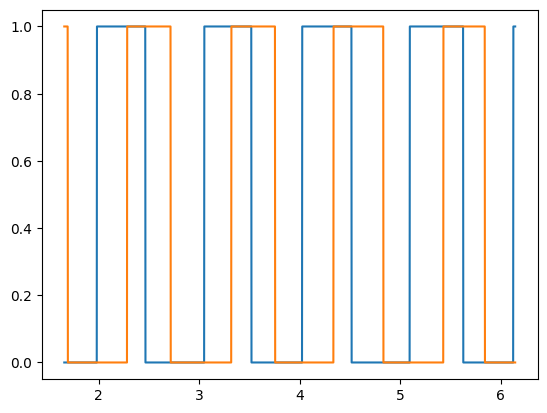

In [667]:
plt.plot(body_fit_points[1000:3000], body_bin_rh1[1000:3000])
plt.plot(body_fit_points[1000:3000], body_bin_rh2[1000:3000])
#plt.plot(body_fit_points[1000:3000], body_bin_rh3[1000:3000])

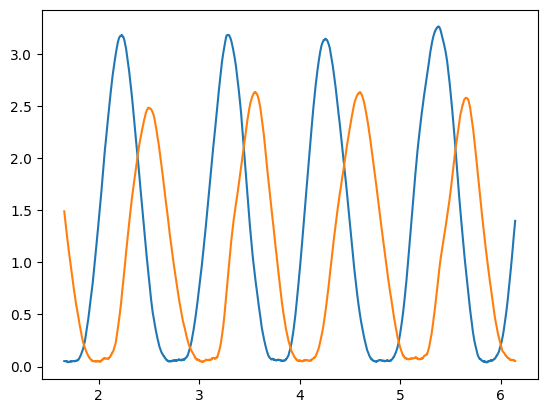

In [668]:
plt.plot(body_fit_points[1000:3000], body_rh1[1000:3000])
plt.plot(body_fit_points[1000:3000], body_rh2[1000:3000])

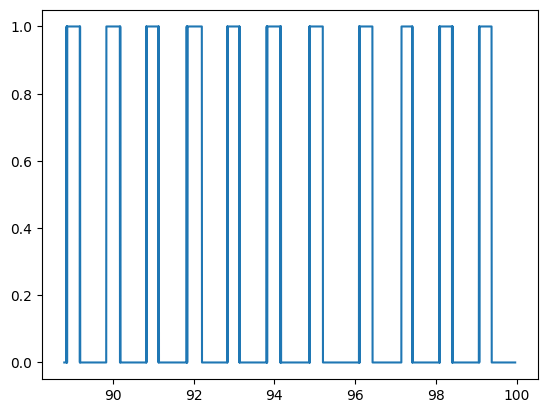

In [551]:
plt.plot(body_fit_points[40000:45000], body_bin_rh3[40000:45000])

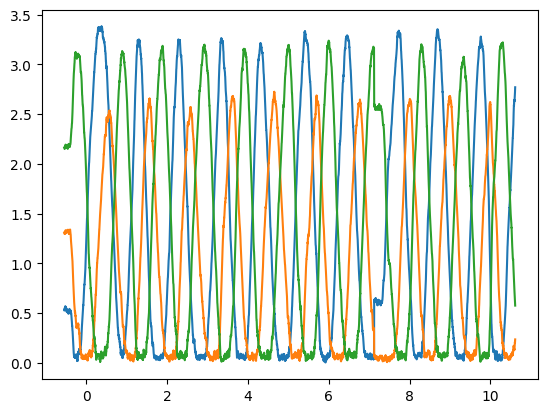

In [553]:
plt.plot(body_fit_points[0:5000], body_rh1[0:5000])
plt.plot(body_fit_points[0:5000], body_rh2[0:5000])
plt.plot(body_fit_points[0:5000], body_rh3[0:5000])

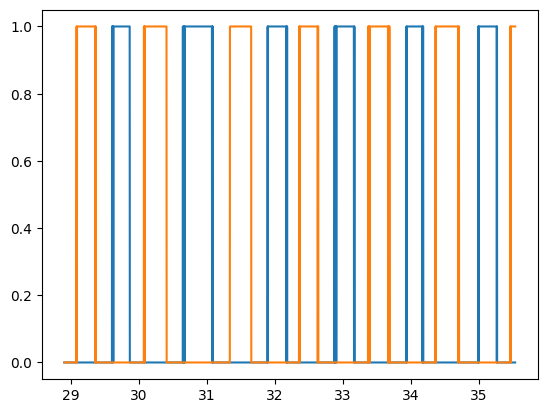

In [526]:
plt.plot(intro_fit_points[13000:16000], intro_bin_rh1[13000:16000])
#plt.plot(intro_fit_points[13000:16000], intro_bin_rh2[13000:16000])
plt.plot(intro_fit_points[13000:16000], intro_bin_rh3[13000:16000])

In [528]:
# Curious to see how things would look if I summed the three RH channels
rh_sum = []
for inc, val in enumerate(intro_rh1):
    rh_sum.append(intro_rh1[inc] + intro_rh2[inc] + intro_rh3[inc])


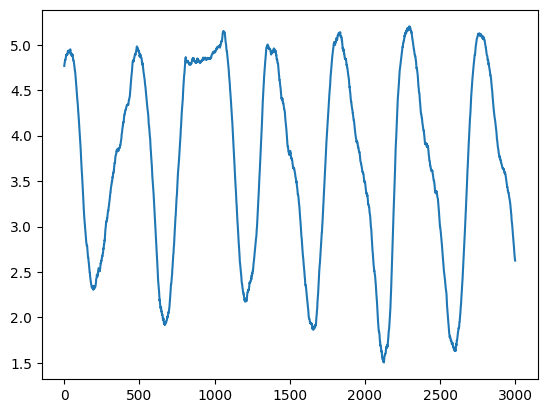

In [530]:
plt.plot(rh_sum[13000:16000])

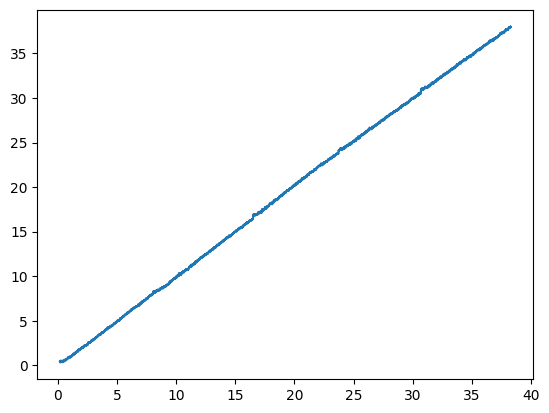

In [522]:
#plt.plot(vals, fit_points)
plt.plot(intro_fit_points, intro_sense)

In [188]:
set1 = datRecs[3]
vals_sense = []
vals_rh1 = []
vals_rh2 = []
vals_rh3 = []
for rec in set1['vals_sense']:
    vals_sense.append((set1['vals_sense'][0] - rec) * adc_mm)
for rec in set1['vals_rh1']:
    vals_rh1.append(rec * adc_sense)
for rec in set1['vals_rh2']:
    vals_rh2.append(rec * adc_sense)
for rec in set1['vals_rh3']:
    vals_rh3.append(rec * adc_sense)

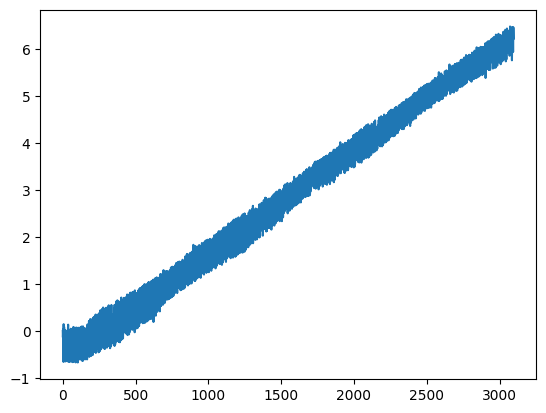

In [189]:
plt.plot(vals_sense)

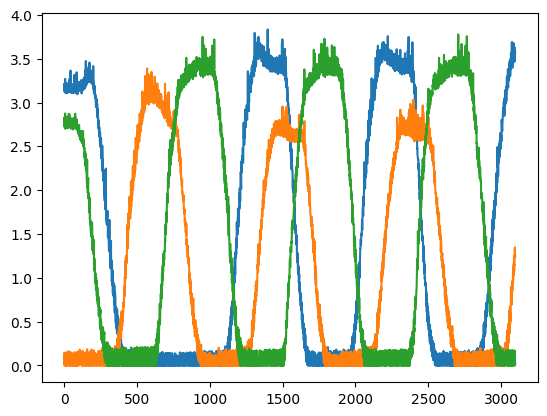

In [190]:
plt.plot(vals_rh1)
plt.plot(vals_rh2)
plt.plot(vals_rh3)

In [145]:
bin_rh1 = []
bin_rh2 = []
bin_rh3 = []
for val in vals_rh1:
    if val > 1.5:
        bin_rh1.append(1)
    else:
        bin_rh1.append(0)
for val in vals_rh2:
    if val > 1.5:
        bin_rh2.append(1)
    else:
        bin_rh2.append(0)
for val in vals_rh3:
    if val > 1.5:
        bin_rh3.append(1)
    else:
        bin_rh3.append(0)

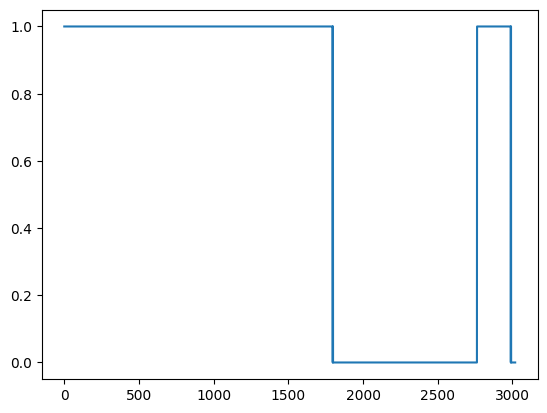

In [147]:
plt.plot(bin_rh3)

In [149]:
vals = np.linspace(0, len(vals_sense), len(vals_sense))
reg = linear_model.LinearRegression()
sub_t1 = np.array(vals)
sub_t2 = np.array(vals_sense)
sub_sense = np.array(vals_sense)
reg.fit(sub_t1.reshape((-1,1)), sub_sense)
print(f'Slope: {round(reg.coef_[0], 4)} mm/degC')
fit_points = []
for val in vals:
    fit_point = val * reg.coef_[0] + reg.intercept_
    fit_points.append(fit_point)

Slope: 0.0024 mm/degC


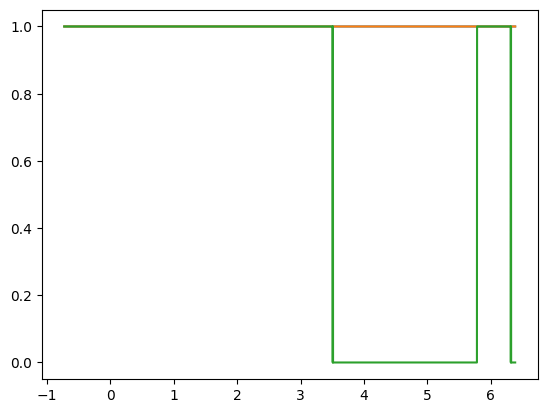

In [150]:
plt.plot(fit_points, bin_rh1)
plt.plot(fit_points, bin_rh2)
plt.plot(fit_points, bin_rh3)

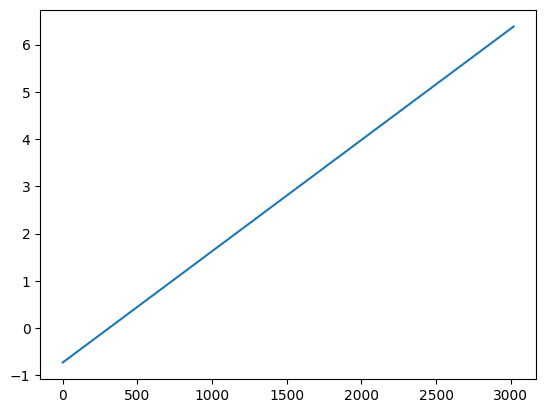

In [151]:
plt.plot(vals, fit_points)

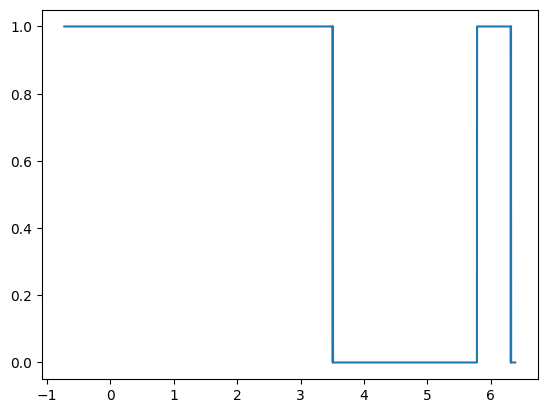

In [152]:
plt.plot(fit_points, bin_rh3)

In [47]:
print(2**14)

16384
